In [2]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
!pip install folium
import folium
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 94 kB 7.6 MB/s  eta 0:00:01


In [6]:
res = requests.get("https://en.wikipedia.org/wiki/List_of_cities_in_Canada")
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0] 
df = pd.read_html(str(table))[0]

In [11]:
df

,Geographic area,Capital
0,Canada,Ottawa
1,Alberta,Edmonton
2,British Columbia,Victoria
3,Manitoba,Winnipeg
4,New Brunswick,Fredericton
5,Newfoundland and Labrador,St. John's
6,Nova Scotia,Halifax
7,Ontario,Toronto
8,Prince Edward Island,Charlottetown
9,Quebec,Quebec City


In [12]:
df.rename(columns={'Geographic area':'State'},inplace=True)
df.head()

,State,Capital
0,Canada,Ottawa
1,Alberta,Edmonton
2,British Columbia,Victoria
3,Manitoba,Winnipeg
4,New Brunswick,Fredericton


In [13]:
coun_lati = list()
coun_longi = list()
for state,capital in zip(df['State'] ,df['Capital']) :
    geolocator = Nominatim(user_agent="foursquare_agent")
    try:
        location = geolocator.geocode(capital + ','+state )
        latitude = location.latitude
        longitude = location.longitude
        coun_lati.append(latitude)
        coun_longi.append(longitude)
    except:
        coun_lati.append(None)
        coun_longi.append(None)

In [14]:
df['latitude'] = coun_lati
df['longitude'] = coun_longi
df.head()

,State,Capital,latitude,longitude
0,Canada,Ottawa,45.421143,-75.690057
1,Alberta,Edmonton,53.535411,-113.507996
2,British Columbia,Victoria,48.428318,-123.364953
3,Manitoba,Winnipeg,49.895537,-97.138458
4,New Brunswick,Fredericton,45.947959,-66.653362


In [15]:
CLIENT_ID = 'LEDAHVH5I01NHOYAAZGDCXONTSEU3DF15BU2WAF202222NKS' # your Foursquare ID
CLIENT_SECRET = 'TP0AB41G22SAUDTWRTM152KOMUUOJWV11YRHY4NYENGG1GRF' # your Foursquare Secret
ACCESS_TOKEN = 'A2Z4X5ROCI24BLSQ2MKYUKTWMFMJ0EZTLRFFQ0G0AB5WBJMP' # your FourSquare Access Token AZ13AGEZOZL051UJHQ4XNMJX3R1TAJCTD3NQPZJLGLAMGKRQ#_=_
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: LEDAHVH5I01NHOYAAZGDCXONTSEU3DF15BU2WAF202222NKS
CLIENT_SECRET:TP0AB41G22SAUDTWRTM152KOMUUOJWV11YRHY4NYENGG1GRF


In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000,LIMIT=200):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'], 
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Capital', 
                  'Capital Latitude', 
                  'Capital Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
canada_venues = getNearbyVenues(names=df['Capital'],
                                   latitudes=df['latitude'],
                                   longitudes=df['longitude']
                                  )

Ottawa
Edmonton
Victoria
Winnipeg
Fredericton
St. John's
Halifax
Toronto
Charlottetown
Quebec City
Regina
Yellowknife
Iqaluit
Whitehorse


In [18]:
canada_venues.head()

,Capital,Capital Latitude,Capital Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ottawa,45.421143,-75.690057,National Arts Centre - Centre National des Arts,45.422922,-75.692996,Concert Hall
1,Ottawa,45.421143,-75.690057,Confederation Park,45.422069,-75.692518,Park
2,Ottawa,45.421143,-75.690057,Beckta Dining & Wine,45.420567,-75.692717,Restaurant
3,Ottawa,45.421143,-75.690057,freshii,45.423250,-75.687178,Salad Place
4,Ottawa,45.421143,-75.690057,Genji Japanese Restaurant,45.418981,-75.692465,Japanese Restaurant


In [20]:
canada_venues.groupby(['Capital'])['Venue'].count()

Capital
Charlottetown     71
Edmonton         100
Fredericton      100
Halifax          100
Iqaluit           13
Ottawa           100
Quebec City      100
Regina            84
St. John's        76
Toronto          100
Victoria         100
Whitehorse        37
Winnipeg         100
Yellowknife       41
Name: Venue, dtype: int64

In [21]:
canada_onehot = pd.get_dummies(canada_venues[['Venue Category']], prefix="", prefix_sep="")
canada_onehot['Capital'] = canada_venues['Capital'] 
fixed_columns = [canada_onehot.columns[-1]] + list(canada_onehot.columns[:-1])
canada_onehot = canada_onehot[fixed_columns]

canada_onehot.head()

,Capital,Airport,Airport Terminal,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,Ottawa,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Ottawa,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Ottawa,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Ottawa,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Ottawa,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
canada_grouped = canada_onehot.groupby('Capital').mean().reset_index()
canada_grouped

,Capital,Airport,Airport Terminal,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,Charlottetown,0.000000,0.014085,0.000000,0.00000,0.00,0.014085,0.014085,0.00,0.014085,...,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.014085,0.00,0.00
1,Edmonton,0.000000,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.02,0.000000,...,0.01,0.020000,0.000000,0.00,0.01,0.000000,0.01,0.000000,0.00,0.00
2,Fredericton,0.000000,0.000000,0.010000,0.01000,0.01,0.000000,0.000000,0.00,0.000000,...,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00
3,Halifax,0.000000,0.000000,0.010000,0.01000,0.00,0.000000,0.000000,0.00,0.020000,...,0.02,0.030000,0.010000,0.01,0.00,0.010000,0.00,0.000000,0.01,0.00
4,Iqaluit,0.153846,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.00,0.000000,...,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00
5,Ottawa,0.000000,0.000000,0.000000,0.02000,0.01,0.000000,0.010000,0.00,0.010000,...,0.00,0.010000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.02,0.00
6,Quebec City,0.000000,0.000000,0.000000,0.00000,0.00,0.000000,0.020000,0.00,0.040000,...,0.00,0.000000,0.000000,0.00,0.00,0.010000,0.00,0.000000,0.00,0.00
7,Regina,0.000000,0.000000,0.000000,0.00000,0.00,0.000000,0.011905,0.00,0.011905,...,0.00,0.011905,0.011905,0.00,0.00,0.011905,0.00,0.000000,0.00,0.00
8,St. John's,0.000000,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.00,0.026316,...,0.00,0.013158,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00
9,Toronto,0.000000,0.000000,0.020000,0.03000,0.00,0.010000,0.000000,0.01,0.000000,...,0.00,0.010000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.02,0.00


In [23]:
num_top_venues = 5

for hood in canada_grouped['Capital']:
    print("----"+hood+"----")
    temp = canada_grouped[canada_grouped['Capital'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Charlottetown----
                  venue  freq
0           Coffee Shop  0.08
1  Fast Food Restaurant  0.08
2        Sandwich Place  0.07
3         Grocery Store  0.07
4           Pizza Place  0.06


----Edmonton----
                venue  freq
0  Italian Restaurant  0.08
1                Café  0.07
2          Restaurant  0.04
3                 Bar  0.04
4         Coffee Shop  0.04


----Fredericton----
                  venue  freq
0            Restaurant  0.09
1           Coffee Shop  0.09
2  Fast Food Restaurant  0.07
3                   Pub  0.05
4                   Bar  0.04


----Halifax----
                venue  freq
0          Restaurant  0.07
1         Coffee Shop  0.06
2                 Pub  0.04
3      Breakfast Spot  0.04
4  Italian Restaurant  0.04


----Iqaluit----
                       venue  freq
0                Coffee Shop  0.23
1                    Airport  0.15
2  Middle Eastern Restaurant  0.08
3          Convenience Store  0.08
4          Mobile Phone Shop  

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [26]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Capital']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Capital'] = canada_grouped['Capital']

for ind in np.arange(canada_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(canada_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Capital,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Charlottetown,Fast Food Restaurant,Coffee Shop,Sandwich Place,Grocery Store,Pizza Place,Clothing Store,Gym,Diner,Restaurant,Convenience Store
1,Edmonton,Italian Restaurant,Café,Restaurant,Bar,Coffee Shop,Pizza Place,Hotel,French Restaurant,Nightclub,Indian Restaurant
2,Fredericton,Restaurant,Coffee Shop,Fast Food Restaurant,Pub,Café,Bar,Pharmacy,Sandwich Place,Brewery,Grocery Store
3,Halifax,Restaurant,Coffee Shop,Italian Restaurant,Pub,Breakfast Spot,Burger Joint,Music Venue,Sushi Restaurant,Bar,Café
4,Iqaluit,Coffee Shop,Airport,Beer Store,Middle Eastern Restaurant,Mobile Phone Shop,Grocery Store,Department Store,Restaurant,Convenience Store,Rental Service


In [27]:
kclusters = 5

canada_grouped_clustering = canada_grouped.drop('Capital', 1)


kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(canada_grouped_clustering)


kmeans.labels_[0:10]

array([3, 1, 4, 1, 2, 1, 4, 1, 4, 1], dtype=int32)

In [33]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

canada_merged = df

canada_merged = canada_merged.join(neighborhoods_venues_sorted.set_index('Capital'), on='Capital')

canada_merged.head()

,State,Capital,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Canada,Ottawa,45.421143,-75.690057,1,Coffee Shop,Hotel,Restaurant,Concert Hall,New American Restaurant,Tapas Restaurant,Café,Pizza Place,Park,Museum
1,Alberta,Edmonton,53.535411,-113.507996,1,Italian Restaurant,Café,Restaurant,Bar,Coffee Shop,Pizza Place,Hotel,French Restaurant,Nightclub,Indian Restaurant
2,British Columbia,Victoria,48.428318,-123.364953,1,Breakfast Spot,Coffee Shop,Restaurant,Café,Hotel,Italian Restaurant,Gastropub,Seafood Restaurant,Brewery,Bakery
3,Manitoba,Winnipeg,49.895537,-97.138458,1,Coffee Shop,Asian Restaurant,Sushi Restaurant,Pizza Place,Bakery,Sandwich Place,French Restaurant,Pub,Café,Vietnamese Restaurant
4,New Brunswick,Fredericton,45.947959,-66.653362,4,Restaurant,Coffee Shop,Fast Food Restaurant,Pub,Café,Bar,Pharmacy,Sandwich Place,Brewery,Grocery Store


In [34]:
latitude = 39.381266
longitude = -97.922211
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=4)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(canada_merged['latitude'], canada_merged['longitude'], canada_merged['Capital'], canada_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

[]

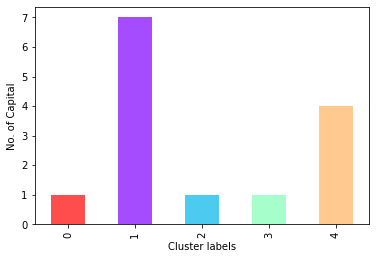

In [67]:
import matplotlib.pyplot as plt

x = canada_merged.groupby('Cluster Labels')['Capital'].count()
x.plot(kind ='bar', color=plt_color,alpha=0.7,linewidth=4)

plt.xlabel('Cluster labels')
plt.ylabel('No. of Capital')
ax.set_yticks([])

In [37]:
C1= canada_merged[canada_merged['Cluster Labels']==0].groupby(['1st Most Common Venue']).size().sort_values(ascending=False)
print(f"most common venue in cluster 0 is {C1.index[0]}")

most common venue in cluster 0 is Coffee Shop


In [40]:
C2= canada_merged[canada_merged['Cluster Labels']==1].groupby(['1st Most Common Venue']).size().sort_values(ascending=False)
print(f"most common venue in cluster 1 is {C2.index[0]}")

most common venue in cluster 1 is Coffee Shop


In [41]:
C3= canada_merged[canada_merged['Cluster Labels']==2].groupby(['1st Most Common Venue']).size().sort_values(ascending=False)
print(f"most common venue in cluster 2 is {C2.index[0]}")

most common venue in cluster 2 is Coffee Shop


In [42]:
C2= canada_merged[canada_merged['Cluster Labels']==3].groupby(['1st Most Common Venue']).size().sort_values(ascending=False)
print(f"most common venue in cluster 3 is {C2.index[0]}")

most common venue in cluster 1 is Fast Food Restaurant


In [43]:
C5 =canada_merged[canada_merged['Cluster Labels']==4]
C5

,State,Capital,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,New Brunswick,Fredericton,45.947959,-66.653362,4,Restaurant,Coffee Shop,Fast Food Restaurant,Pub,Café,Bar,Pharmacy,Sandwich Place,Brewery,Grocery Store
5,Newfoundland and Labrador,St. John's,47.561701,-52.715149,4,Restaurant,Pub,Coffee Shop,Bar,Gastropub,Hotel,Café,Pharmacy,Seafood Restaurant,Pizza Place
9,Quebec,Quebec City,46.825960,-71.235223,4,Restaurant,Café,Brewery,Bakery,Pizza Place,Gastropub,Park,Liquor Store,Pharmacy,Grocery Store
11,Northwest Territories,Yellowknife,62.454081,-114.377385,4,Restaurant,Sandwich Place,Grocery Store,Vietnamese Restaurant,Coffee Shop,Fast Food Restaurant,Pizza Place,Juice Bar,Paper / Office Supplies Store,Shopping Mall
